# Network Modeling with SEIRS+ Notebook 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from network_utils import *
from stats_utils import *
from intervention_utils import *

### Parameters

Here, we define the parameters taken from the Tucker model. These can be customized further and then the rest of the cells can be run. For now we are only using the population in isoboxes to run our experiments and create the network, but we will soon include the tent population as well!

In [2]:
n_pop = 18700

# Isoboxes
n_isoboxes = 812
pop_isoboxes = 8100
pop_per_isobox = 10
max_pop_per_isobox  = poisson.rvs(mu=pop_per_isobox, size=n_isoboxes) # According to the model, this is drawn through a poison distribution

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# Isobox grid parameters - can be extended to tents as well
grid_width = 29
grid_height = 28

# We define neighboring isoboxes as any isobox within a range of 2 in the isobox grid
iso_proximity = 2

### Basic Network

#### 1) Create isobox graph - can be used to create tent graphs as well

In [7]:
iso_weight = 0.98 # Edge weight for connections within each isobox
graph, nodes_per_isobox = create_graph(n_isoboxes, pop_isoboxes, max_pop_per_isobox, iso_weight, "household")

100%|██████████| 8100/8100 [00:01<00:00, 7963.78it/s]


#### 2) Create the grid that will help with positioning when measuring proximity

In [8]:
isobox_grid = create_grid(grid_width, grid_height)

#### 3) Connect the nodes that are within a certain degree of proximity - can be used for tents as well

In [9]:
neighbor_weight = 0.017 # Edge weight for connections between isoboxes
graph = connect_neighbors(graph, n_isoboxes, nodes_per_isobox, isobox_grid, iso_proximity, neighbor_weight, "friendship")

#### 4) Connect the nodes that go to the food line - can be extended to all nodes
Assumption: 2 people from each isobox are randomly selected to get food, and then we connect each person from the food queue with the previous + next 5 people near them.

In [10]:
food_weight = 0.407 # Edge weight for connections in the food queue 
graph = connect_food_queue(graph, nodes_per_isobox, food_weight, "food_bois") 

#### 5) Plot the basic network degrees

In [11]:
min_G, max_G = min_degree(graph), max_degree(graph)
min_G, max_G

(11, 75)

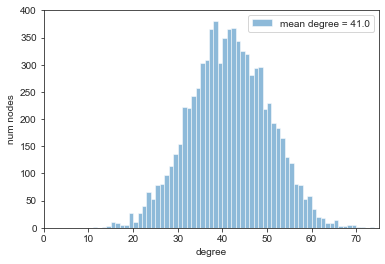

In [12]:
plot_degree_distn(graph, max_degree=max_G)

### Quarantine/Social Distancing Network

#### 1) Create simple quarantine graph
NOTE: We should tweak the reduction scale depending on what we want our mean degree to be + the min_neighbors parameter depending on how many people we think a person will be in contact with during a social distancing scenario

In [ ]:
reduction_scale = 10 # Exponential distribution parameter. Setting it to 20 gives a mean of ~10, when the past mean was ~40
min_neighbors = 4 # The minimum number of connections that a person would hold in a distancing/quarantine scenario

In [ ]:
Q = custom_exponential_graph(graph, scale=reduction_scale, min_num_edges=min_neighbors)

#### 2) Plot quarantine graph degrees

In [ ]:
min_Q, max_Q = min_degree(Q), max_degree(Q)
min_Q, max_Q

In [ ]:
plot_degree_distn(Q, max_degree=max_Q)

### Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

In [ ]:
interventions = Interventions()

In [ ]:
interventions.add(15, Q)
interventions.add(45, graph)
interventions.add("dummy", Q)

In [ ]:
interventions.get_checkpoints()

In [ ]:
interventions.remove('dummy')

In [ ]:
interventions.get_checkpoints()

In [37]:
beta = 1.28
sigma = 1/5.1
gamma = 0.056
initI = 10
mu = list(sample_population(pop_isoboxes)["death_rate"])
a = list(1 - sample_population(pop_isoboxes)["prob_symptomatic"])
# checkpoints = interventions.get_checkpoints()

ref_model = SymptomaticSEIRSNetworkModel(G=graph, beta=beta, sigma=sigma, gamma=gamma, lamda=sigma, mu_0=0, p=0.5, a=a, f=mu, q=0.5,
                          initI_S=1, initI_A=0)

fig_name = f"SymptomaticModel_Infections_IsoWeight={iso_weight}_NeighWeight={neighbor_weight}_FoodWeight={food_weight}_Beta={beta}_Gamma={gamma}_Sigma={sigma}_initI={initI}"
ref_model.run(T=40)#, checkpoints=checkpoints)

t = 10.03
t = 20.00
t = 30.00
t = 40.00


True

In [45]:
ref_model.run(T=40)

t = 40.01
t = 50.01
t = 60.00
t = 70.00
t = 80.00


True

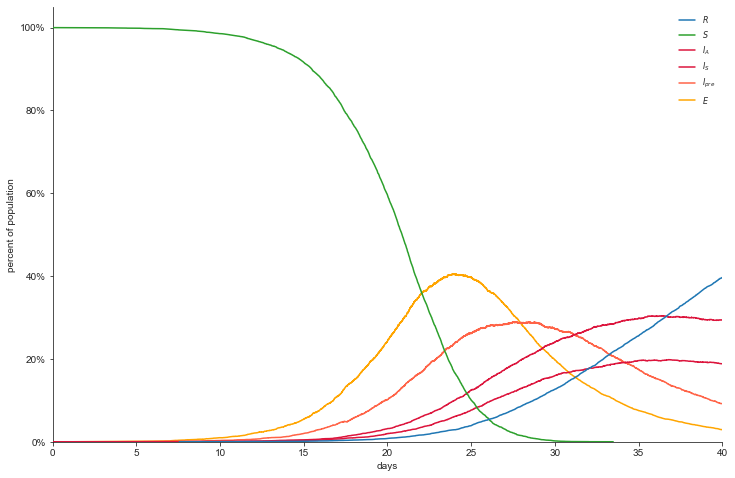

In [38]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"{fig_name}_figBasic.png")

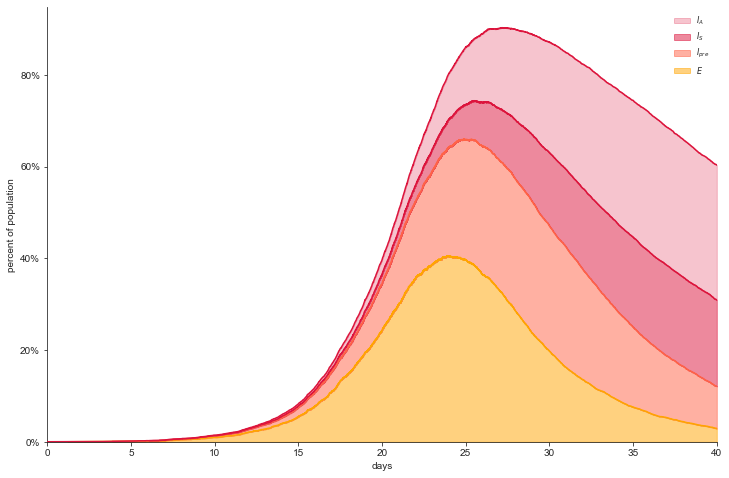

In [39]:
fig, ax = ref_model.figure_infections()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"{fig_name}_figInfections.png")

In [44]:
[node for node in graph.nodes if ref_model.X[node][0] == 8]

[]

In [43]:
ref_model.X

array([[5],
       [3],
       [5],
       ...,
       [5],
       [5],
       [5]])